In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
df = pd.read_csv('train.csv')

# Drop invalid or missing target rows
df = df[~df['Genetic Disorder'].isin(['-99', np.nan])]
df = df.dropna(subset=['Genetic Disorder'])


In [14]:
# Drop irrelevant columns
drop_cols = ['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
             'Institute Name', 'Location of Institute', 'Disorder Subclass']
X = df.drop(columns=drop_cols + ['Genetic Disorder'])

# Fill missing values
X = X.fillna(method='ffill').fillna(method='bfill')

# One-hot encoding for categorical variables
X = pd.get_dummies(X)

# Encode target labels
y = df['Genetic Disorder']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

<ipython-input-14-901aaff74f73>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [16]:
model = Sequential()

# First dense layer
model.add(Dense(256, input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Hidden layers
for _ in range(5):
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=1)


val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\n Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f" Validation Loss: {val_loss:.4f}")

print("\n Target Label Classes:")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4371 - loss: 1.1349 - val_accuracy: 0.5089 - val_loss: 0.9301
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4815 - loss: 0.9602 - val_accuracy: 0.5515 - val_loss: 0.8722
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5258 - loss: 0.8884 - val_accuracy: 0.5859 - val_loss: 0.8348
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5642 - loss: 0.8471 - val_accuracy: 0.5971 - val_loss: 0.8181
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5722 - loss: 0.8268 - val_accuracy: 0.6058 - val_loss: 0.8089
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5830 - loss: 0.8210 - val_accuracy: 0.6085 - val_loss: 0.8073
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5963 - loss: 0.8043 - val_accuracy: 0.6031 - val_loss: 0.8075
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5986 - loss: 0.8003 - val_

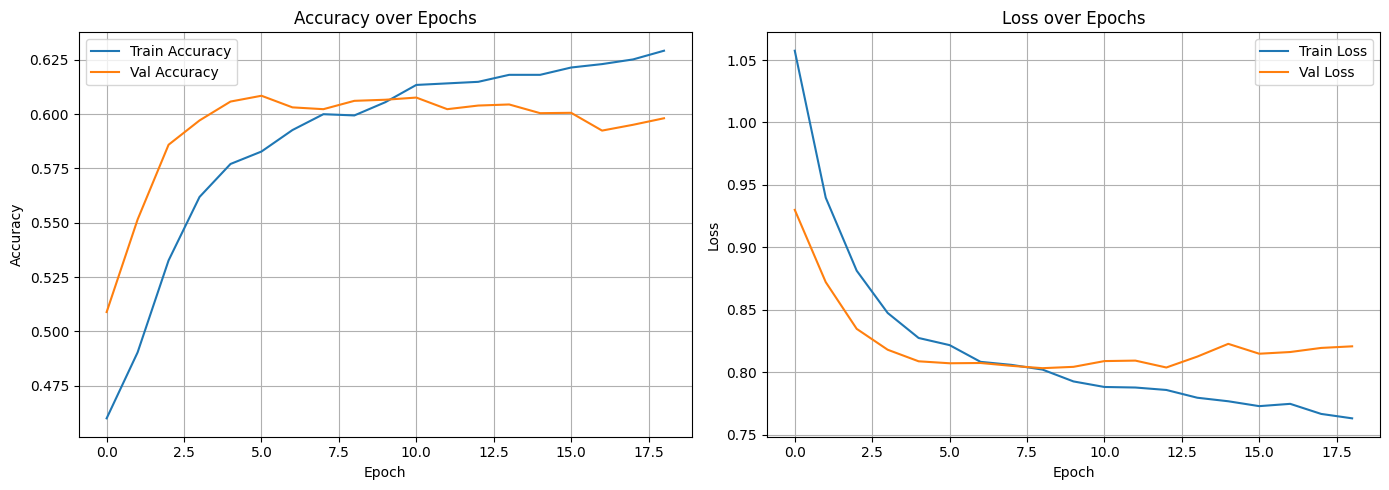

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)